In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install optuna > /dev/null

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(style='seaborn')
%matplotlib inline
import tensorflow as tf

In [4]:
tf.random.set_seed(47)
np.random.seed(47)

In [5]:
import optuna
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

In [6]:
plt.rcParams['figure.figsize'] = (16,6)

In [7]:
from google.colab import files
uploaded = files.upload()

Saving WST.csv to WST.csv


In [8]:
df = pd.read_csv('WST.csv')
df['Date'] = pd.to_datetime(df.Date)

In [9]:
# Include only the desired columns (Open, Close, Low, High, Adj Close) and drop 'Volume'
df = df[['Date', 'Open', 'Close', 'Low', 'High', 'Adj Close']]

# Optionally, you can rename the columns for consistency
df.columns = ['Date', 'Open', 'Close', 'Low', 'High', 'Adj Close']

# Display the first few rows of the updated DataFrame
print(df.head())

        Date       Open      Close        Low       High  Adj Close
0 2010-01-04  19.780001  19.735001  19.655001  19.860001  17.623144
1 2010-01-05  19.760000  19.485001  19.379999  19.760000  17.399900
2 2010-01-06  19.434999  19.295000  19.209999  19.520000  17.230234
3 2010-01-07  19.290001  19.355000  19.075001  19.385000  17.283815
4 2010-01-08  19.230000  19.350000  19.230000  19.440001  17.279345


In [10]:
df.describe()

,Date,Open,Close,Low,High,Adj Close
count,2640,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000
mean,2015-04-01 01:20:43.636363776,64.870786,64.931924,64.199847,65.557335,63.022981
min,2010-01-04 00:00:00,16.510000,16.520000,16.370001,16.580000,14.936180
25%,2012-08-14 18:00:00,24.937501,24.902501,24.668749,25.101251,23.280846
50%,2015-04-01 12:00:00,54.594999,54.635000,53.965000,55.015000,52.525897
75%,2017-11-10 18:00:00,94.039999,94.090002,93.190003,94.754999,91.924742
max,2020-06-29 00:00:00,224.820007,223.360001,220.779999,226.669998,221.359222
std,NaN,43.405762,43.463528,42.872345,43.993996,43.466416


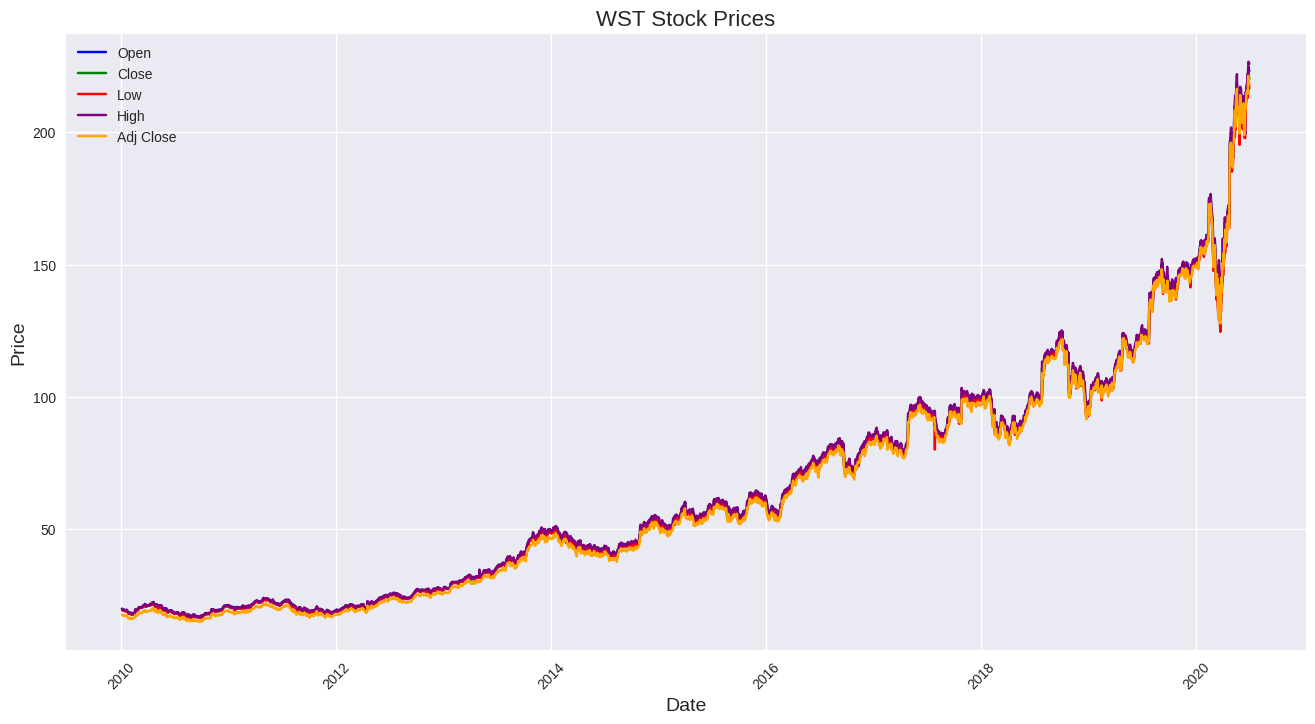

In [12]:
plt.figure(figsize=(16, 8))  # Set the figure size

plt.title('WST Stock Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)

# Plot all price columns
plt.plot(df['Date'], df['Open'], label='Open', color='blue')
plt.plot(df['Date'], df['Close'], label='Close', color='green')
plt.plot(df['Date'], df['Low'], label='Low', color='red')
plt.plot(df['Date'], df['High'], label='High', color='purple')
plt.plot(df['Date'], df['Adj Close'], label='Adj Close', color='orange')

plt.legend()  # Show legend
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Show grid
plt.show()

In [13]:
# Calculate the average price for each day
df['avg_price'] = df[['Open', 'Close', 'Low', 'High', 'Adj Close']].mean(axis=1)

# Calculate percentage change based on the average price
df['returns'] = df['avg_price'].pct_change() * 100

# Drop any rows with missing values generated by pct_change()
df.dropna(inplace=True)

# Reset the index after dropping rows
df.reset_index(drop=True, inplace=True)

# Display the DataFrame to verify the changes
print(df.head())

        Date       Open      Close        Low       High  Adj Close  \
0 2010-01-05  19.760000  19.485001  19.379999  19.760000  17.399900   
1 2010-01-06  19.434999  19.295000  19.209999  19.520000  17.230234   
2 2010-01-07  19.290001  19.355000  19.075001  19.385000  17.283815   
3 2010-01-08  19.230000  19.350000  19.230000  19.440001  17.279345   
4 2010-01-11  19.455000  19.264999  19.145000  19.455000  17.203442   

   avg_price   returns  
0  19.156980 -0.898313  
1  18.938046 -1.142840  
2  18.877763 -0.318317  
3  18.905869  0.148883  
4  18.904688 -0.006247  


In [14]:
# Create a new DataFrame 'data' with all price features and returns
data = df[['Date', 'Open', 'Close', 'Low', 'High', 'Adj Close', 'returns']]

# Display the first few rows of the new DataFrame
print(data.head())

        Date       Open      Close        Low       High  Adj Close   returns
0 2010-01-05  19.760000  19.485001  19.379999  19.760000  17.399900 -0.898313
1 2010-01-06  19.434999  19.295000  19.209999  19.520000  17.230234 -1.142840
2 2010-01-07  19.290001  19.355000  19.075001  19.385000  17.283815 -0.318317
3 2010-01-08  19.230000  19.350000  19.230000  19.440001  17.279345  0.148883
4 2010-01-11  19.455000  19.264999  19.145000  19.455000  17.203442 -0.006247


In [15]:
# Convert the 'data' DataFrame to a NumPy array
data_array = data.values

# Display the shape of the array
print("Shape of the NumPy array:", data_array.shape)

# Optionally, display the array
print(data_array)

Shape of the NumPy array: (2639, 7)
[[Timestamp('2010-01-05 00:00:00') 19.76 19.485001 ... 19.76 17.3999
  -0.898313213761015]
 [Timestamp('2010-01-06 00:00:00') 19.434999 19.295 ... 19.52 17.230234
  -1.1428398421880814]
 [Timestamp('2010-01-07 00:00:00') 19.290001 19.355 ... 19.385 17.283815
  -0.3183168882720522]
 ...
 [Timestamp('2020-06-25 00:00:00') 217.729996 223.360001 ... 223.570007
  221.359222 1.9185207291326112]
 [Timestamp('2020-06-26 00:00:00') 224.820007 222.449997 ... 226.669998
  220.457352 1.2711938818533497]
 [Timestamp('2020-06-29 00:00:00') 223.080002 220.130005 ... 225.899994
  218.158142 -1.0221885307600709]]


In [16]:
# Drop the 'Date' column from the DataFrame
data = data.drop('Date', axis=1).values

# Display the shape of the array
print("Shape of the NumPy array:", data.shape)

# Optionally, display the array
print(data)

Shape of the NumPy array: (2639, 6)
[[ 19.76        19.485001    19.379999    19.76        17.3999
   -0.89831321]
 [ 19.434999    19.295       19.209999    19.52        17.230234
   -1.14283984]
 [ 19.290001    19.355       19.075001    19.385       17.283815
   -0.31831689]
 ...
 [217.729996   223.360001   215.160004   223.570007   221.359222
    1.91852073]
 [224.820007   222.449997   220.779999   226.669998   220.457352
    1.27119388]
 [223.080002   220.130005   216.509995   225.899994   218.158142
   -1.02218853]]


In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_data = train_test_split(data, test_size=0.05, shuffle=False)
X_val, X_test = train_test_split(X_data, test_size=0.50, shuffle=False)

print(X_train.shape, X_val.shape, X_test.shape, sep='\n')

(2507, 6)
(66, 6)
(66, 6)


In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [21]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [22]:
LAG_DAYS = 1

# Generate Training set
train_gen = TimeseriesGenerator(X_train, X_train[:,0], length=LAG_DAYS, batch_size=1)

print('Train Samples: %d' % len(train_gen))

x_train, y_train = [], []
for i in range(len(train_gen)):
    x, y = train_gen[i]
    x_train.append(x[0])
    y_train.append(y[0])
x_train = np.array(x_train)
y_train = np.array(y_train)

# Generate Validation set
val_gen = TimeseriesGenerator(X_val, X_val[:,0], length=LAG_DAYS, batch_size=1)

print('Validation Samples: %d' % len(val_gen))

x_val, y_val = [], []
for i in range(len(val_gen)):
    x, y = val_gen[i]
    x_val.append(x[0])
    y_val.append(y[0])
x_val = np.array(x_val)
y_val = np.array(y_val)

# Generate Test set
test_gen = TimeseriesGenerator(X_test, X_test[:,0], length=LAG_DAYS, batch_size=1)

print('Test Samples: %d' % len(test_gen))

x_test, y_test = [], []
for i in range(len(test_gen)):
    x, y = test_gen[i]
    x_test.append(x[0])
    y_test.append(y[0])
x_test = np.array(x_test)
y_test = np.array(y_test)

Train Samples: 2506
Validation Samples: 65
Test Samples: 65


In [23]:
def prep_data_transform(data, length):
    '''Prepare data for inverse transform'''
    a = []
    a.append(data)
    [a.append(np.zeros(data.shape)) for i in range(1,length)]
    return np.c_[a].T

In [24]:
Y_train = np.round(scaler.inverse_transform(prep_data_transform(y_train, X_train.shape[1])))[:,0]
Y_val = np.round(scaler.inverse_transform(prep_data_transform(y_val, X_val.shape[1])))[:,0]
Y_test = np.round(scaler.inverse_transform(prep_data_transform(y_test, X_test.shape[1])))[:,0]

print(Y_train.shape, Y_val.shape, Y_test.shape)

(2506,) (65,) (65,)


In [25]:
x_train[1], y_train[0]

(array([[0.02187242, 0.02075232, 0.02133893, 0.02169421, 0.01716244,
         0.32487369]]),
 0.021872421226634964)

In [26]:
x_val[1], y_val[0]

(array([[0.99940177, 1.00448692, 0.99571712, 0.99476087, 1.00444007,
         0.43016932]]),
 0.9994017722499897)

In [27]:
x_test[1], y_test[0]

(array([[0.94429065, 0.93149863, 0.91885189, 0.95786595, 0.93327907,
         0.37455838]]),
 0.944290647413047)

In [28]:
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt

In [29]:
import optuna
import tensorflow as tf
from tensorflow.keras.layers import ConvLSTM2D, Dense, Dropout, Reshape, Flatten
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
import numpy as np

In [30]:
%%time
# Define EarlyStopping callback
early_stopping_rounds = EarlyStopping(monitor='loss', patience=50)

def run(trial):
    space = {
        'optimizer': trial.suggest_categorical('optimizer', ['Adam', 'RMSprop']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True),
        'epochs': trial.suggest_int('epochs', 50, 200),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64])
    }

    n_timesteps = x_train.shape[1]  # Assuming x_train is your input data
    n_features = x_train.shape[2]

    x_train_reshaped = x_train.reshape((x_train.shape[0], n_timesteps, 1, n_features, 1))
    x_val_reshaped = x_val.reshape((x_val.shape[0], n_timesteps, 1, n_features, 1))

    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                         input_shape=(n_timesteps, 1, n_features, 1),
                         return_sequences=True, padding='same'))

    model.add(Reshape((-1, 64)))
    model.add(Flatten())
    # Change the number of units in the Dense layer to match the shape of y_train or y_val
    model.add(Dense(units=1))  # Output a single value for each input
    model.add(Dropout(0.2))

    if space['optimizer'] == 'Adam':
        optimizer = optimizers.Adam(learning_rate=space['learning_rate'])
    else:
        optimizer = optimizers.RMSprop(learning_rate=space['learning_rate'])

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

    model.fit(x_train_reshaped, y_train, epochs=space['epochs'], validation_data=(x_val_reshaped, y_val),
              batch_size=space['batch_size'], callbacks=[early_stopping_rounds], verbose=0)

    yhat_val = model.predict(x_val_reshaped)

    rmse = mean_squared_error(y_val, yhat_val, squared=False) if not np.isnan(yhat_val).any() else 99999
    return rmse

# Hyperparameter Optimization with Conv LSTM
study = optuna.create_study(direction='minimize')
study.optimize(run, n_trials=10, n_jobs=-1)
print('Best trial: {}'.format(study.best_trial))

[I 2024-07-03 09:51:34,305] A new study created in memory with name: no-name-8483d647-a4b7-4e31-b186-5edcdf3cac60


3/3 [==============================] - 1s 8ms/step


[I 2024-07-03 09:54:03,275] Trial 0 finished with value: 0.1988441830913693 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.00011196003642403457, 'epochs': 141, 'batch_size': 32}. Best is trial 0 with value: 0.1988441830913693.


3/3 [==============================] - 0s 7ms/step


[I 2024-07-03 09:55:31,189] Trial 2 finished with value: 0.20082854589747687 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.0002490768564585541, 'epochs': 132, 'batch_size': 32}. Best is trial 0 with value: 0.1988441830913693.


3/3 [==============================] - 1s 14ms/step


[I 2024-07-03 09:57:24,633] Trial 3 finished with value: 0.20621079082068774 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.0014868598437060984, 'epochs': 102, 'batch_size': 32}. Best is trial 0 with value: 0.1988441830913693.


3/3 [==============================] - 1s 12ms/step


[I 2024-07-03 09:57:47,107] Trial 1 finished with value: 0.2027529955460496 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.002413523577529376, 'epochs': 176, 'batch_size': 16}. Best is trial 0 with value: 0.1988441830913693.


3/3 [==============================] - 0s 6ms/step


[I 2024-07-03 09:59:11,406] Trial 4 finished with value: 0.2069563706266717 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.0015486036110483607, 'epochs': 52, 'batch_size': 16}. Best is trial 0 with value: 0.1988441830913693.


3/3 [==============================] - 1s 8ms/step


[I 2024-07-03 09:59:16,692] Trial 5 finished with value: 0.2059111271828088 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.0019786159474515118, 'epochs': 197, 'batch_size': 64}. Best is trial 0 with value: 0.1988441830913693.


3/3 [==============================] - 1s 11ms/step


[I 2024-07-03 10:00:05,340] Trial 7 finished with value: 0.1936903537749664 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.0004488058219892199, 'epochs': 65, 'batch_size': 32}. Best is trial 7 with value: 0.1936903537749664.


3/3 [==============================] - 0s 10ms/step


[I 2024-07-03 10:02:11,115] Trial 6 finished with value: 0.21825916073323992 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.0026965281710331075, 'epochs': 150, 'batch_size': 64}. Best is trial 7 with value: 0.1936903537749664.


3/3 [==============================] - 0s 10ms/step


[I 2024-07-03 10:02:35,450] Trial 8 finished with value: 0.20015665742883765 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 5.0635383177502456e-05, 'epochs': 122, 'batch_size': 16}. Best is trial 7 with value: 0.1936903537749664.


3/3 [==============================] - 0s 5ms/step


[I 2024-07-03 10:03:56,827] Trial 9 finished with value: 0.2026181647370879 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.00015710586257003295, 'epochs': 74, 'batch_size': 16}. Best is trial 7 with value: 0.1936903537749664.


Best trial: FrozenTrial(number=7, state=TrialState.COMPLETE, values=[0.1936903537749664], datetime_start=datetime.datetime(2024, 7, 3, 9, 59, 16, 730169), datetime_complete=datetime.datetime(2024, 7, 3, 10, 0, 5, 339557), params={'optimizer': 'Adam', 'learning_rate': 0.0004488058219892199, 'epochs': 65, 'batch_size': 32}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'optimizer': CategoricalDistribution(choices=('Adam', 'RMSprop')), 'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'epochs': IntDistribution(high=200, log=False, low=50, step=1), 'batch_size': CategoricalDistribution(choices=(16, 32, 64))}, trial_id=7, value=None)
CPU times: user 18min 41s, sys: 47.5 s, total: 19min 29s
Wall time: 12min 22s


In [31]:
best_params = study.best_params
best_params

{'optimizer': 'Adam',
 'learning_rate': 0.0004488058219892199,
 'epochs': 65,
 'batch_size': 32}

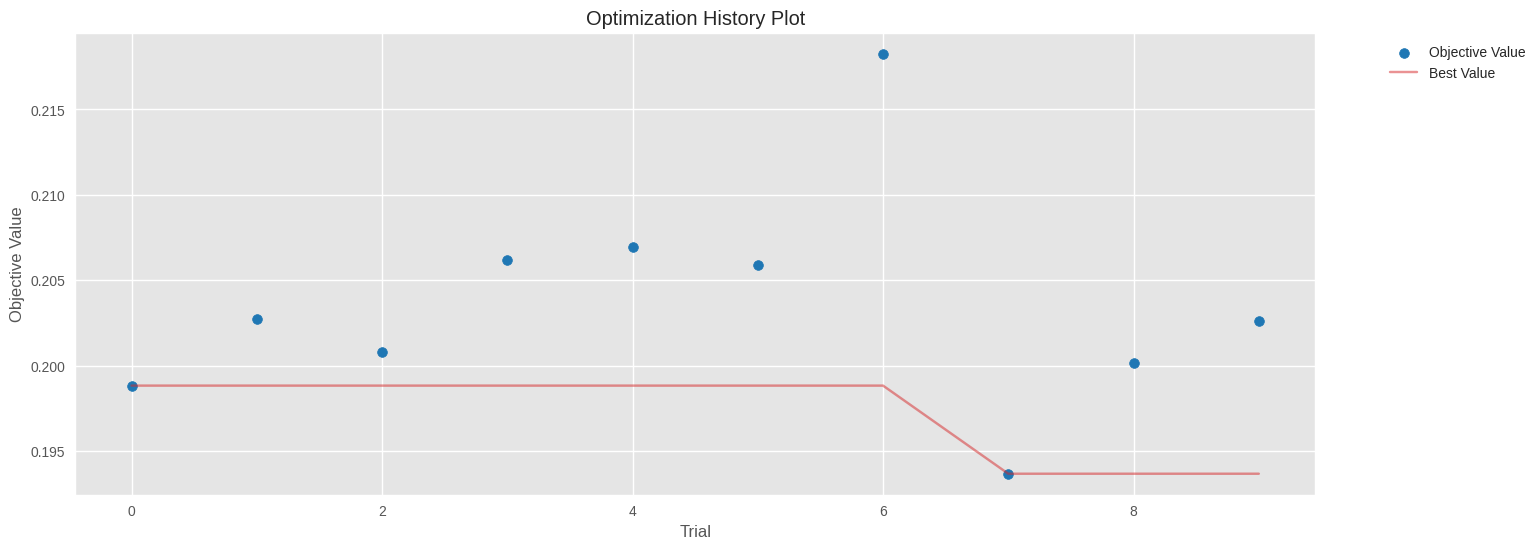

In [32]:
plot_optimization_history(study);

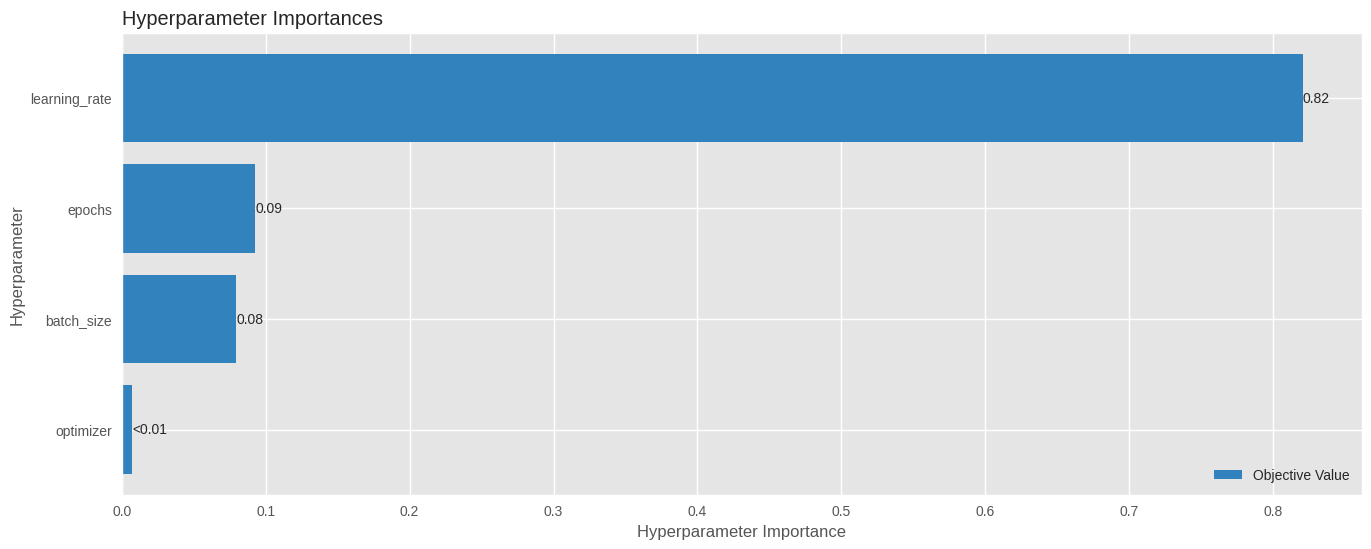

In [33]:
plot_param_importances(study);

In [34]:
optuna.visualization.plot_slice(study, params=['epochs', 'learning_rate'])

In [36]:
# Define the LSTM model using the best hyperparameters
model = Sequential()
model.add(LSTM(units=best_params["units"], input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(rate=best_params["dropout_rate"]))
model.add(Dense(units=1))

# Compile the model with the best optimizer and learning rate
if best_params['optimizer'] == 'Adam':
    optimizer = optimizers.Adam(learning_rate=best_params['learning_rate'])
else:
    optimizer = optimizers.RMSprop(learning_rate=best_params['learning_rate'])

model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                18176     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18241 (71.25 KB)
Trainable params: 18241 (71.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


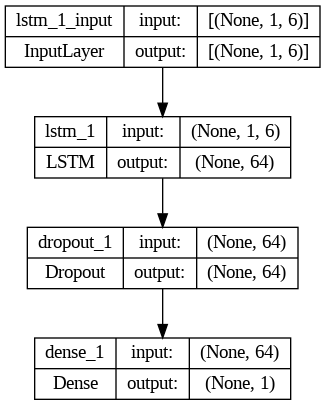

In [37]:
plot_model(model, show_shapes=True)

In [38]:
%%time
history = model.fit(x_train, y_train, epochs=best_params['epochs'], validation_data=(x_val, y_val), batch_size=best_params['batch_size'], verbose=0)

CPU times: user 39.3 s, sys: 1.28 s, total: 40.6 s
Wall time: 43.1 s


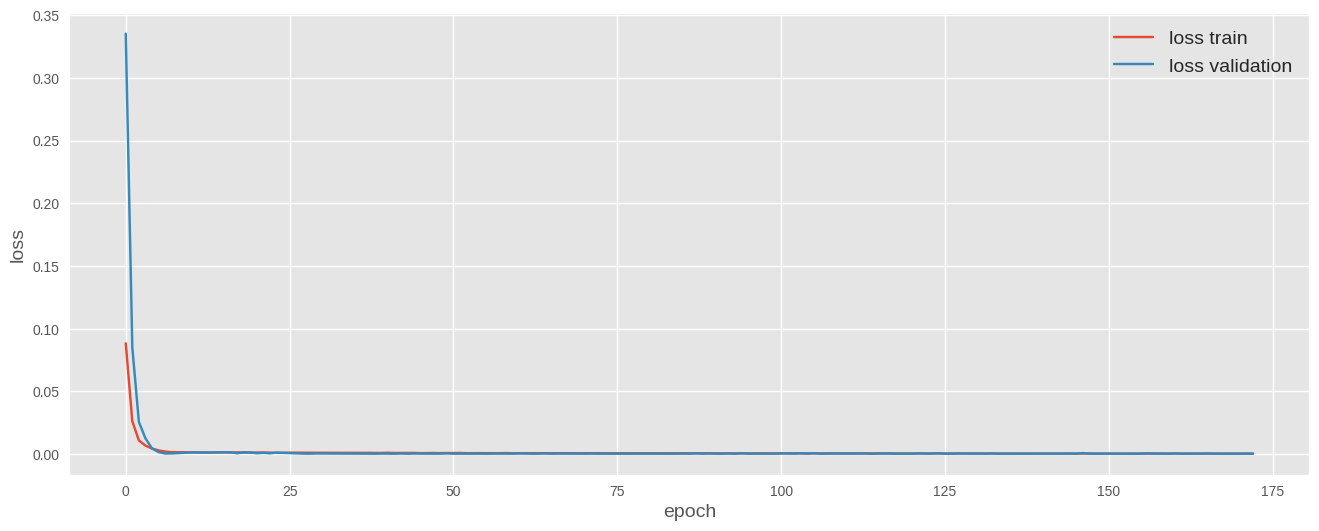

In [39]:
plt.plot(history.history['loss'], label='loss train')
plt.plot(history.history['val_loss'], label='loss validation')
plt.xlabel('epoch', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [40]:
model.evaluate(x_test, y_test, batch_size=best_params['batch_size'])

2/2 [==============================] - 0s 8ms/step - loss: 0.0015 - accuracy: 0.0000e+00


[0.0015070060035213828, 0.0]

In [41]:
yhat_train = np.squeeze(model.predict(x_train))
yhat_test = np.squeeze(model.predict(x_test))

3/3 [==============================] - 0s 4ms/step


In [42]:
yhat_train = scaler.inverse_transform(prep_data_transform(yhat_train, X_train.shape[1]))[:,0]
yhat_test = scaler.inverse_transform(prep_data_transform(yhat_test, X_test.shape[1]))[:,0]
print(yhat_train.shape, yhat_test.shape)

(2506,) (65,)


In [43]:
print('Train Predicted: ', yhat_train[:5])
print('Train Actual: ', Y_train[:5])

print('Test Predicted: ', yhat_test[:5])
print('Test Actual: ', Y_test[:5])

Train Predicted:  [20.03217836 19.83242687 19.73082741 19.73802516 19.74297311]
Train Actual:  [19. 19. 19. 19. 19.]
Test Predicted:  [144.21350408 141.60508119 150.29801742 154.81837934 147.732239  ]
Test Actual:  [143. 144. 153. 149. 149.]


In [44]:
# calculate root mean squared error
trainScore = mean_squared_error(Y_train, yhat_train, squared=False)
print('Train Score: %.2f RMSE' % (trainScore))

testScore = mean_squared_error(Y_test, yhat_test, squared=False)
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.71 RMSE
Test Score: 5.23 RMSE


In [45]:
date_train = df['Date'][LAG_DAYS:len(Y_train) + LAG_DAYS]
date_test = df['Date'][-len(Y_test):]

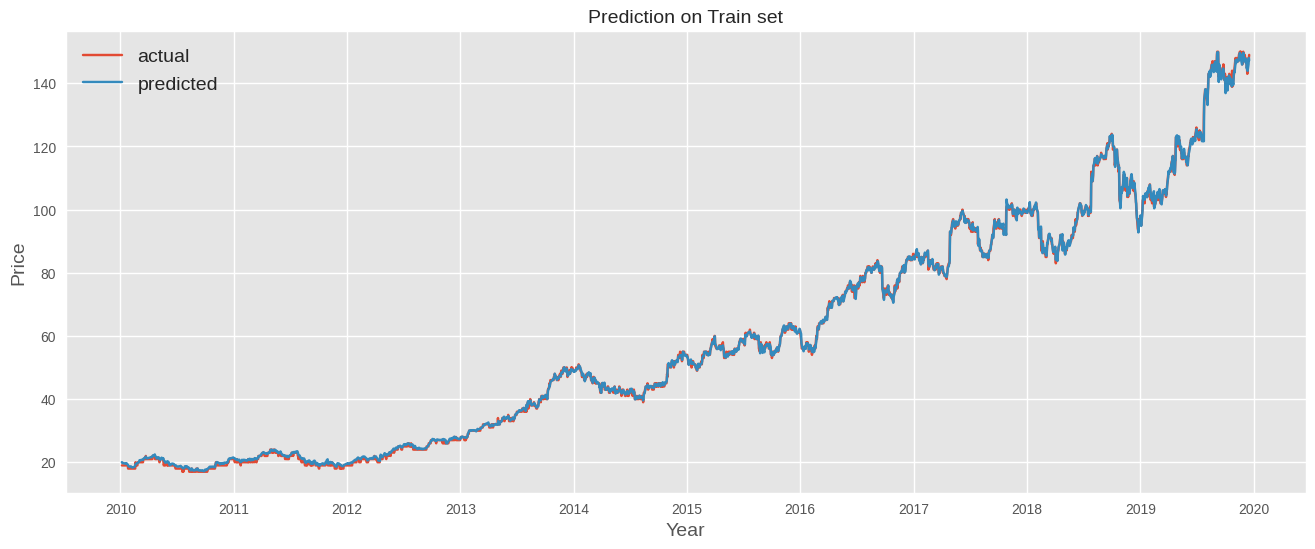

In [46]:
plt.title('Prediction on Train set', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.plot(date_train, Y_train, label='actual')
plt.plot(date_train, yhat_train, label='predicted')
plt.legend(fontsize=14)
plt.show()

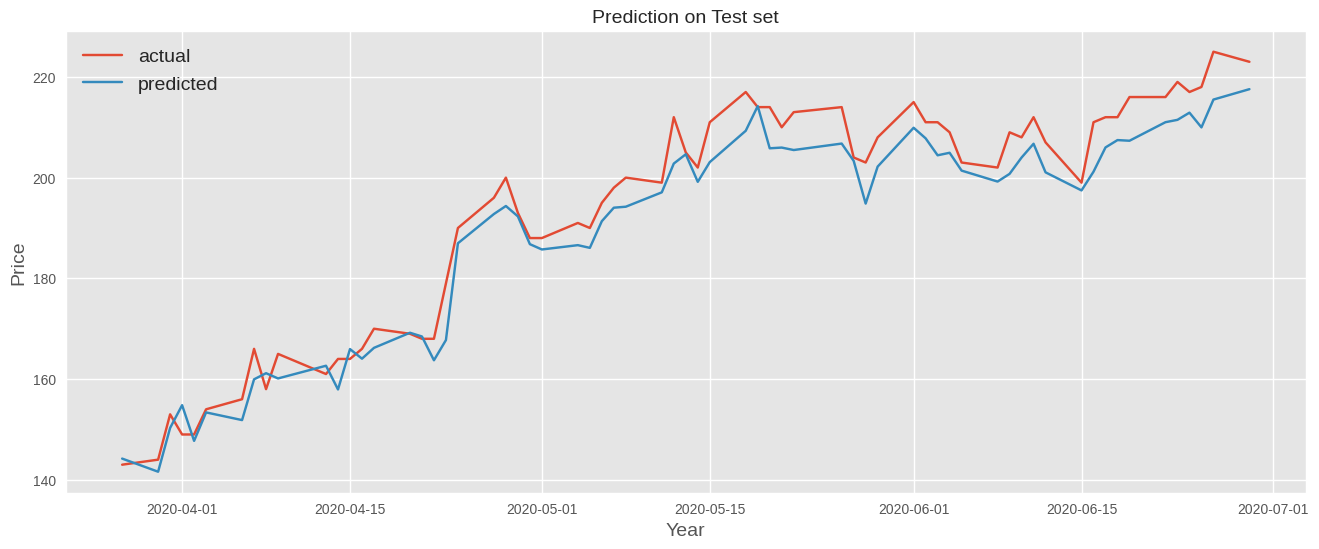

In [47]:
plt.title('Prediction on Test set', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.plot(date_test, Y_test, label='actual')
plt.plot(date_test, yhat_test, label='predicted')
plt.legend(fontsize=14)
plt.show()

In [48]:
yhat_test

array([144.21350408, 141.60508119, 150.29801742, 154.81837934,
       147.732239  , 153.38114105, 151.85768919, 159.95312455,
       161.16787826, 160.12783138, 162.64910013, 157.94017791,
       165.95663731, 164.05105909, 166.20073905, 169.19927517,
       168.4561773 , 163.73442189, 167.74389505, 186.96445228,
       192.77245408, 194.3670704 , 192.30318952, 186.78953821,
       185.73437845, 186.59103018, 186.05538372, 191.34910115,
       194.02962907, 194.22512409, 197.07715453, 202.793666  ,
       204.63904776, 199.16931626, 203.08057163, 209.30043135,
       214.20448193, 205.82491481, 205.96660606, 205.47961415,
       206.76325263, 203.32991825, 194.84264794, 202.18991592,
       209.90416549, 207.8031082 , 204.43368473, 204.9347533 ,
       201.393365  , 199.21953312, 200.74456322, 203.9867866 ,
       206.72591679, 201.05149183, 197.46187941, 201.18066872,
       205.99506227, 207.45530466, 207.32322636, 211.00678416,
       211.47407193, 212.89819007, 209.97633429, 215.49

In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'Y_test' contains actual values and 'yhat_test' contains predicted values

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(Y_test, yhat_test)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(Y_test, yhat_test)

# Calculate R-squared (R2) score
r2 = r2_score(Y_test, yhat_test)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2) Score: {r2}')

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((Y_test - yhat_test) / Y_test)) * 100

# Display the Mean Absolute Percentage Error (MAPE)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Squared Error (MSE): 27.365472748231575
Root Mean Squared Error (RMSE): 5.231201845487476
Mean Absolute Error (MAE): 4.467193594940817
R-squared (R2) Score: 0.9487702360161541
Mean Absolute Percentage Error (MAPE): 2.27%


In [50]:
# Assuming 'Y_train' contains actual values and 'yhat_train' contains predicted values

# Calculate Mean Absolute Percentage Error (MAPE)
mape_train = np.mean(np.abs((Y_train - yhat_train) / Y_train)) * 100

# Display the Mean Absolute Percentage Error (MAPE) for the training set
print(f'Mean Absolute Percentage Error (MAPE) on Training set: {mape_train:.2f}%')

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'Y_train' contains the actual values and 'yhat_train' contains the predicted values for the training set

# Calculate Mean Squared Error (MSE) on the training set
mse_train = mean_squared_error(Y_train, yhat_train)

# Calculate Root Mean Squared Error (RMSE) on the training set
rmse_train = np.sqrt(mse_train)

# Calculate Mean Absolute Error (MAE) on the training set
mae_train = mean_absolute_error(Y_train, yhat_train)

# Calculate R-squared (R2) score on the training set
r2_train = r2_score(Y_train, yhat_train)

# Display the accuracy metrics for the training set
print(f'Mean Squared Error (MSE) on Training set: {mse_train:.2f}')
print(f'Root Mean Squared Error (RMSE) on Training set: {rmse_train:.2f}')
print(f'Mean Absolute Error (MAE) on Training set: {mae_train:.2f}')
print(f'R-squared (R2) Score on Training set: {r2_train:.2f}')

Mean Absolute Percentage Error (MAPE) on Training set: 1.21%
Mean Squared Error (MSE) on Training set: 0.50
Root Mean Squared Error (RMSE) on Training set: 0.71
Mean Absolute Error (MAE) on Training set: 0.50
R-squared (R2) Score on Training set: 1.00


In [51]:
import numpy as np

def calculate_forecast_accuracy(yhat_test, Y_test):
    # Calculate the forecast accuracy using the given formula
    accuracy = 1 - np.abs(yhat_test - Y_test) / Y_test
    return accuracy

# Compute forecast accuracy for the test set
forecast_accuracy = calculate_forecast_accuracy(yhat_test, Y_test)

# Calculate the mean accuracy across all data points
mean_accuracy = np.mean(forecast_accuracy)

print(f'Mean Forecast Accuracy on Test Set: {mean_accuracy:.2f}')

Mean Forecast Accuracy on Test Set: 0.98


In [52]:
def calculate_forecast_accuracy(yhat_train, Y_train):
    # Calculate the forecast accuracy using the given formula
    accuracy = 1 - np.abs(yhat_train - Y_train) / Y_train
    return accuracy

# Compute forecast accuracy for the training set
forecast_accuracy_train = calculate_forecast_accuracy(yhat_train, Y_train)

# Calculate the mean accuracy across all data points
mean_accuracy_train = np.mean(forecast_accuracy_train)

print(f'Mean Forecast Accuracy on Training Set: {mean_accuracy_train:.2f}')

Mean Forecast Accuracy on Training Set: 0.99
